In [4]:
# -*- coding: utf-8 -*-
"""
The script demonstrates the performance of an interpolation algorithm when applied to a large dataset.
"""

import os
import pandas as pd
import matplotlib.pyplot as plt
from scipy import interpolate
from itertools import compress
import time
%matplotlib inline  
#import sys
#sys.path.append('/gpfs2/projects/project-bus_capstone_2016/workspace/mu529/Bus-Capstone')

# these two modules are homemade
import gtfs
import arrivals
import time
import ttools
import seqtools
os.chdir('/gpfs2/projects/project-bus_capstone_2016/workspace/share')

### Previous versions of the interpolation function. (final version is below)

### Current working version of interpolation function.
Takes several lists as inputs, which can be stored together as a dataframe row (merged_row).

merged_row.shape_stop_dist is a list of distances of *all* stops from the schedule on that shape.<p>
mergedrow.shape_stop_id is a list of stop_id labels for those stops<p>

In [5]:
# for iteration over dataframe rows (each row is a collection of lists of necessary data)
def interpolate_stops5(merged_row,tol=100):
    distance_stops = merged_row.shape_stop_dist
    # if the returned object is not a list, it does not contain any information, so there is nothing to interpolate.
    if type(distance_stops) != list:
        return [[]]
    # if there are fewer than 2 pings, no interpolation is possible
    if len(merged_row.recorded_time)<2:
        return [[]]    
    # assemble the ping data as a pandas Series, for convenient use of dropna() method
    list1, list2 = zip(*sorted(zip(merged_row.recorded_time,merged_row.veh_dist_along_shape)))
    veh_pings = pd.Series(index=list1,data=list2)
    veh_pings = veh_pings.dropna()
    # pings must be cleaned for cases when the vehicle "moves backwards" along the route.
    # this may occur when the vehicle is actually finishing another trip, or returning to the first stop
    # the proposed method is to identify the the largest monotonic increasing subsequence
    first, last = seqtools.longest_inc_range(veh_pings.values,tolerance=tol)
    if len(veh_pings) == 0:
        return [[]]
    valid_pings = veh_pings.iloc[first:last]
    if len(valid_pings)<2:
        return [[]]
    # finally, perform the interpolation with the cleaned data
    x = valid_pings.values
    y = valid_pings.index.values
    f = interpolate.interp1d(x,y)
    xnew = distance_stops
    masker = (xnew > min(x)) & (xnew < max(x))
    xnew = list(compress(xnew,masker))
    # return the estimated times (as timedelta dtype) and the stop labels
    interp_times = pd.to_timedelta(f(xnew),unit='ns')
    return [list(compress(merged_row.shape_stop_id,masker)),interp_times]

## Now try it on a WHOLE WEEK of data...

In [6]:
# get the sample of parsed AVL data.  Beware, large files take more time.
bustime = pd.read_csv('nov2015_extract_cleaned.csv')

In [7]:
bustime.head()

,ROUTE_ID,latitude,longitude,recorded_time,vehicle_id,TRIP_ID,trip_date,SHAPE_ID,STOP_ID,distance_stop,distance_shape,status,destination
0,Q66,40.759376,-73.830754,2015-11-09T23:42:16.000,598,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-11-10,Q660138,503845,0.01,0.01,at stop,505066
1,Q66,40.759376,-73.830754,2015-11-09T23:43:51.000,598,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-11-10,Q660138,503845,0.01,0.01,at stop,505066
2,Q33,40.746975,-73.890510,2015-11-09T23:43:57.000,3595,9942542-LGPD5-LG_D5-Weekday-10-SDon,2015-11-10,Q330098,503311,87.75,296.69,approaching,552017
3,Q66,40.759376,-73.830754,2015-11-09T23:44:53.000,598,9866275-CPPD5-CP_D5-Weekday-10-SDon,2015-11-10,Q660138,503845,0.01,0.01,at stop,505066
4,Q33,40.746975,-73.890510,2015-11-09T23:45:01.000,3595,9942542-LGPD5-LG_D5-Weekday-10-SDon,2015-11-10,Q330098,503311,87.75,296.69,approaching,552017


#### Additional cleaning steps
Remove prefixes from trip and shape labels.  (GTFS data does not use the prefix).  Distance values need to be numeric, not string.

In [8]:
# beware!  Bonan is still working on organizing the extract files.  these columns may change.

bustime.drop_duplicates(['vehicle_id','recorded_time'],inplace=True)
#bustime['trip_id'] = bustime['trip_id'].str.replace('MTA NYCT_','')
#bustime['trip_id'] = bustime['trip_id'].str.replace('MTABC_','')
#bustime['shape_id'] = bustime['shape_id'].str.replace('MTA_','')

bustime.set_index(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id'],inplace=True,drop=True)
bustime.set_index('recorded_time',append=True,drop=False,inplace=True)

# for demonstration, use a subset. Just get data one day.
#tripDateLookup = "2015-12-03"
#bustime = bustime.xs((tripDateLookup),level=(2),drop_level=False)
# note that the AVL dataframe must be sorted by timestammp, since iloc[]
# selection is used later in this script to find the earliest time
bustime.sort_index(inplace=True)

In [9]:
bustime['distance_shape'] = bustime['distance_shape'].convert_objects(convert_numeric=True)
bustime['distance_stop'] = bustime['distance_stop'].convert_objects(convert_numeric=True)
# add calculated column for distance along shape
bustime['veh_dist_along_shape'] = bustime['distance_shape'] - bustime['distance_stop']

print 'Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.'

Finished loading BusTime data, parsing timestamps, and slicing ONE DAY.


In [10]:
for name, group in bustime.groupby(level=2):
    bustime.loc[(slice(None),slice(None),name),'recorded_time'] = group['recorded_time'].apply(ttools.parseActualTime,tdate=name)

In [12]:
bustime.loc[(slice(None),slice(None),'2015-11-13'),'recorded_time'].head()

ROUTE_ID  TRIP_ID                         trip_date   vehicle_id  recorded_time          
B1        UP_D5-Weekday-SDon-006000_B1_1  2015-11-13  7158        2015-11-13T01:01:50.000    3710000000000
                                                                  2015-11-13T01:02:55.000    3775000000000
                                                                  2015-11-13T01:03:58.000    3838000000000
                                                                  2015-11-13T01:05:01.000    3901000000000
                                                                  2015-11-13T01:06:04.000    3964000000000
Name: recorded_time, dtype: object

#### Create a separate dataframe containing the distances of ALL stops along each shape.
Although GTFS is the official source for all stop information, Bus Time has the distances calculated already according to the shape.  The problem is the records from each trip may not contain information about all the stops (for example, when some are skipped).  Using a large enough sample should resolve that problem.

In [13]:
bustime_distances = bustime.drop(['recorded_time'],axis=1,inplace=False)
bustime_distances = bustime_distances.reset_index().drop(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','recorded_time',
                                                'latitude','longitude','distance_stop','status','destination',
                                                'veh_dist_along_shape'],axis=1,inplace=False)

stop_distances = bustime_distances.drop_duplicates(['SHAPE_ID','STOP_ID','distance_shape'])
stop_distances = stop_distances.query('distance_shape > 0.1')

# stop_distances.next_stop_id = stop_distances.next_stop_id.str.replace('MTA_','')

stop_distances = stop_distances.sort(['SHAPE_ID','distance_shape']).reset_index(drop=True)

print 'Finished creating stop-distances reference dataframe.'

Finished creating stop-distances reference dataframe.


## Organization of Bus Time data
A trip is identified as the grouping of records for each route, trip date, trip_id **and** vehicle_id.  Both are required because sometimes trip_id labels are "recycled" during the day and used by two different vehicles serving the route.

In [14]:
# make a copy
avl_data2 = bustime

In [15]:
gb = avl_data2.groupby(level=(0,1,2,3))

For each **trip data group**, take the reported shape_id (single value), which will be used next to get the information about all stops along that shape.<p>
From each group, take the necessary data in list form:
<ol>
<li>time stamps of all the pings</li>
<li>vehicle distances for thosee pings (note: Python list ordering is persistent, so the two lists can be kept separate)</li></ol>

In [16]:
shape_ids = gb['SHAPE_ID'].agg(lambda x:x.value_counts().index[0])
reported_timestamps = gb['recorded_time'].apply(list)
reported_dists = gb['veh_dist_along_shape'].apply(list)

In [17]:
del bustime

... and also take the necessary data (in list form) from each **shape**:
<ol start="3">
<li>labels of all the stops along that shape, from the separate dataframe of stop distances</li>
<li>the distances of all those stops</li><ol>
<br>Also, rename the objects for clarity.  And then merge together.

In [18]:
all_stops = stop_distances.groupby('SHAPE_ID')['STOP_ID'].apply(list)
all_dists = stop_distances.groupby('SHAPE_ID')['distance_shape'].apply(list)
all_dists.name = 'shape_stop_dist'
all_stops.name = 'shape_stop_id'
all_stop_dists = pd.DataFrame(shape_ids).merge(pd.DataFrame(all_dists),left_on='SHAPE_ID',right_index=True).merge(pd.DataFrame(all_stops),left_on='SHAPE_ID',right_index=True)

## Two approaches for consolidated the data.
Approach 1: merge everything into a dataframe

In [19]:
starttime = time.time()
avl_merged = pd.concat([all_stop_dists,reported_timestamps,reported_dists],axis=1)
print 'Processing time:'
print time.time() - starttime

Processing time:
6.18458485603


In [20]:
avl_merged.head(25)

SHAPE_ID  \
ROUTE_ID TRIP_ID                         trip_date  vehicle_id            
B1       UP_D5-Saturday-009800_B1_1      2015-11-14 4858         B10163   
         UP_D5-Saturday-010000_B1_2      2015-11-14 423          B10162   
                                                    4892         B10162   
         UP_D5-Saturday-013800_B1_2      2015-11-14 4892         B10163   
         UP_D5-Saturday-014000_B1_1      2015-11-14 4858         B10162   
         UP_D5-Saturday-017800_B1_1      2015-11-14 4858         B10163   
         UP_D5-Saturday-018000_B1_2      2015-11-14 4892         B10162   
         UP_D5-Saturday-021800_B1_2      2015-11-14 423          B10163   
                                                    4892         B10163   
         UP_D5-Saturday-022000_B1_1      2015-11-14 4858         B10162   
         UP_D5-Saturday-025800_X2737_702 2015-11-14 7174         B10163   
         UP_D5-Saturday-026000_B1_2      2015-11-14 423          B10162   
                                                    4892         B10162   
         UP_D5-Saturday-029600_B3_103    2015-11-14 7153         B10163   
         UP_D5-Saturday-030000_X2737_702 2015-11-14 7174         B10162   
         UP_D5-Saturday-033800_X2737_702 2015-11-14 4858         B10163   
                                                    4892         B10163   
                                                    7174         B10163   
         UP_D5-Saturday-034000_B3_103    2015-11-14 7153         B10162   
         UP_D5-Saturday-037000_B1_1      2015-11-14 4858         B10162   
         UP_D5-Saturday-037600_B3_103    2015-11-14 5081         B10163   
                                                    7153         B10163   
         UP_D5-Saturday-039000_B1_2      2015-11-14 423          B10162   
                                                    4892         B10162   
         UP_D5-Saturday-040100_B1_5      2015-11-14 4868         B10163   

                                                                                                  shape_stop_dist  \
ROUTE_ID TRIP_ID                         trip_date  vehicle_id                                                      
B1       UP_D5-Saturday-009800_B1_1      2015-11-14 4858        [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
         UP_D5-Saturday-010000_B1_2      2015-11-14 423         [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
                                                    4892        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Saturday-013800_B1_2      2015-11-14 4892        [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
         UP_D5-Saturday-014000_B1_1      2015-11-14 4858        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Saturday-017800_B1_1      2015-11-14 4858        [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
         UP_D5-Saturday-018000_B1_2      2015-11-14 4892        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Saturday-021800_B1_2      2015-11-14 423         [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
                                                    4892        [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
         UP_D5-Saturday-022000_B1_1      2015-11-14 4858        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Saturday-025800_X2737_702 2015-11-14 7174        [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
         UP_D5-Saturday-026000_B1_2      2015-11-14 423         [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
                                                    4892        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Saturday-029600_B3_103    2015-11-14 7153        [187.16, 361.71, 567.94, 720.29, 920.63, 1219....   
         UP_D5-Saturday-030000_X2737_702 2015-11-14 7174        [0.44, 289.31, 427.52, 560.27, 845.9, 1002.3, ...   
         UP_D5-Saturday-033800_X2737_702 2015-11

### Compare performance when iterating over dataframe of lists or dict of dicts
Approach 1

Approach 3, using dataframe version but trying longest-increasing subsequence to slice array

In [21]:
starttime = time.time()
results_longest = {}
for i, v in avl_merged.iterrows():
    results_longest[i] = interpolate_stops5(v)
print 'Processing time:'
print time.time() - starttime

Processing time:
300.024837971


In [22]:
import pickle

with open('nov2015_results.pickle', 'wb') as handle:
    pickle.dump(results_longest, handle)

### Expand results into a dataframe (to use for things like headway measurement)

In [23]:
import csv
with open('nov2015_interpolated.csv','w') as out:
    csv_out=csv.writer(out)
    csv_out.writerow(['ROUTE_ID','TRIP_ID','trip_date','vehicle_id','STOP_ID','interpolated_arrival_time'])
    for k, v in results_longest.iteritems():
        for i in range(len(v[0])):
            row = k + (v[0][i],v[1][i])
            csv_out.writerow(row)

## Investigate results and check method for data groups with more than one ping

In [24]:
lens = []
trip_count = 0
for k, v in results_longest.iteritems():
    l = len(v[0])
    if l > 0:
        trip_count += 1
    lens.append(l)
def empty_inds(lst):
    k = results_longest.keys()
    return [k[i] for i, x in enumerate(lst) if x==0]
empty_keys = empty_inds(lens)
print 'Some basic stats: '
print 'Total number of estimated arrival times'
print sum(lens)
print 'Number of trips identified overall'
print len(lens)
print 'Number of trips with estimates'
print trip_count
print 'Number of trips without valid interpolation'
print len(empty_keys)
print 'Average number of estimates per trip'
print 1.0*sum(lens)/trip_count

Some basic stats: 
Total number of estimated arrival times
7857384
Number of trips identified overall
295750
Number of trips with estimates
251061
Number of trips without valid interpolation
44689
Average number of estimates per trip
31.2967127511


In [24]:
ek_index = pd.MultiIndex.from_tuples(empty_keys)
ek_info = pd.DataFrame(data=gb.size(),index=ek_index,columns=['N'])

In [25]:
ek_info['min_ts'] = gb['recorded_time'].min()
ek_info['max_ts'] = gb['recorded_time'].max()
ek_info['min_dist'] = gb['veh_dist_along_shape'].min()
ek_info['max_dist'] = gb['veh_dist_along_shape'].max()

In [26]:
ek_info['ts_delta'] = ek_info['max_ts'] - ek_info['min_ts']
ek_info['dist_delta'] = ek_info['max_dist'] - ek_info['min_dist']

In [27]:
ek_info.groupby('N').size()/len(ek_info)

N
1      0.691066
2      0.124428
3      0.059734
4      0.034402
5      0.020836
6      0.014863
7      0.010691
8      0.007391
9      0.005305
10     0.004475
11     0.003625
12     0.002835
13     0.002774
14     0.002329
15     0.001903
16     0.001235
17     0.001276
18     0.001114
19     0.000992
20     0.000911
21     0.000790
22     0.000486
23     0.000486
24     0.000445
25     0.000526
26     0.000547
27     0.000466
28     0.000223
29     0.000283
30     0.000182
         ...   
42     0.000121
43     0.000061
44     0.000101
45     0.000101
47     0.000061
48     0.000081
49     0.000121
50     0.000040
52     0.000081
53     0.000020
54     0.000061
55     0.000040
56     0.000081
57     0.000020
58     0.000081
59     0.000020
60     0.000020
61     0.000061
64     0.000020
67     0.000081
68     0.000020
70     0.000020
72     0.000020
73     0.000040
74     0.000020
76     0.000020
89     0.000020
95     0.000020
120    0.000020
217    0.000020
dtype: float64

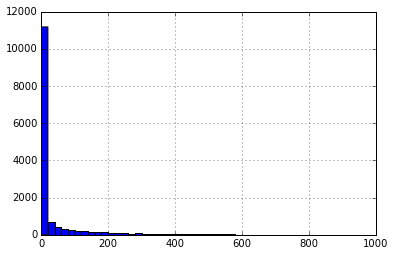

In [28]:
ek_info.query('N>1')['dist_delta'].hist(range=(0,1000),bins=50)

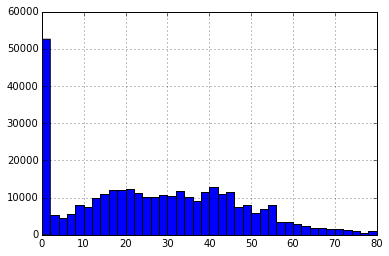

In [29]:
# how many stops were estimated for each trip data group?
pd.Series(lens).hist(range=(0,80),bins=40)

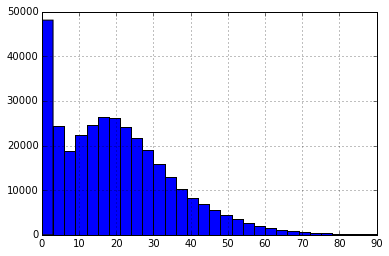

In [30]:
# how many pings were available for each trip data group?
gb.size().hist(range=(0,90),bins=30)